<a target="_blank" href="https://colab.research.google.com/github/SvenLigensa/backpropagation-from-scratch/blob/main/Backpropagation_From_Scratch.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Purpose of this notebook

Further resources:
- [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0): Tutorial video by *Andrej Karpathy* which this notebook is based upon.
- [micrograd](https://github.com/karpathy/micrograd): Code library providing more modular and dense code compared to this notebook
- [Learning representations by back-propagating errors (Rumelhart et al., 1986)](https://www.nature.com/articles/323533a0): Early, mathematical and dense (< 3 pages) paper on backpropagation

Requirements: Knowledge about basics in calculus and deep learning.

This notebook derives how the **training of neural networks via backpropagation** works. To that end both the backpropagation algorithm and the architecture of a simple multilayer perceptron (MLP) are **implemented from scratch**. The linear structure of this notebook allows you to execute all cells from top-to-bottom without being overwhelmed or having to jump around.

The code running in practice is heavily optimized and working with *tensors* (instead of *scalars*), but the **underlying math and principles are the same**.

# Setup

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

Code to visualize the computation graphs

In [2]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root, show_grad = True):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node for it
        if show_grad:
            dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        else:
            dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape = 'record')
        
        if n._op:
            # If this value os a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1, n2 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  
    return dot

# Introduction

At the end, we want to optimize the parameters of neural networks. As neural networks are nothing else than (complicated and very large) functions, finding the right parameters boils down to optimizing a function.

In school and other math courses you probably used the first and second derivative to find minima/maxima of functions. This approach uses **symbolic differentiation** to manipulate the mathematical expression of the function to create a *new expression*: the derivative. The problem is that this approach becomes impractical as the function and the number of its parameters grows. Fortunately, there are two more ways to perform differentiation. **Numerical differentiation** uses the definition of the difference quotient to approximate the slope at a given point for a given function. The approach used to train neural networks is [**automatic differentiation**](https://en.wikipedia.org/wiki/Automatic_differentiation) (AD, aka. autodiff) in its **reverse mode**. Here, blocks of *computer code* provide their own derivatives which are chained together using the *chain rule*.

The rest of the notebook is structured as follows:
- [What is a derivative?](#What-is-a-derivative?): Short recap on *numerical differentiation* to highlight the purpose of a derivative
- [Backpropagation basics (and the `Value` class)](#Backpropagation-basics-(and-the-Value-class)): Developing backpropagation step-by-step 
- [Backpropagation on a simple neuron](#Backpropagation-on-a-simple-neuron): Running backpropagation on a neuron with two inputs
- [Backpropagation with PyTorch](#Backpropagation-with-PyTorch): Using PyTorch for backpropagation
- [Introducing the `Neuron`, `Layer` and `MLP` class](#Introducing-the-Neuron,-Layer-and-MLP-class): Defining the architecture of neural networks
- [Optimizing an MLP with backpropagation](#Optimizing-an-MLP-with-backpropagation): Running backpropagation on an MLP

# What is a derivative?

Look at the example function defined an visualized below:

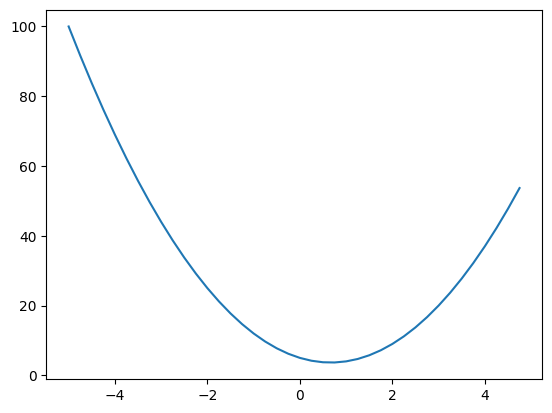

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

xs = np.arange(-5, 5, 0.25)  # Array of sequence of numbers
ys = f(xs)                   # Function values at given x values
plt.plot(xs, ys)             # Plot the function

The formula to calculate the difference quotient is $\underset{h \rightarrow 0}{\lim}\frac{f(x+h)-f(x)}{h}$.
By choosing a smaller and smaller value for $h$, it computes a numerical approximation of the slope of $f$ at the point $x$.

In the next cell, *experiment with different values for $x$ and $h$* to compute the slope at different points with different levels of accuracy.

In [4]:
h = 0.0001       # Choose a small value for h
x = 3.0          # Choose the point where to compute the slope
(f(x+h)-f(x))/h  # Calculate the difference quotient: 14.0003 -> Slope at x = 3.0 is 14

14.000300000063248

We can also generalize this concept to *multivariate* calculus (functions of multiple variables).

In [5]:
# Multivariate function for demo purposes
def d(a, b, c):
    return a*b+c

# Exemplary inputs
a = 2.0
b = -3.0
c = 10.0

h = 0.0001

# Function evaluations
d1 = d(a,b,c)    # At current point
d2 = d(a+h,b,c)  # At slightly different point with a = 2.0001
print(f"d1 = {d1}, d2 = {d2}, slope = {(d2-d1)/h}")  # Slope at given point with respect to a is -3

d1 = d(a,b,c)
d2 = d(a,b+h,c)
print(f"d1 = {d1}, d2 = {d2}, slope = {(d2-d1)/h}")  # Slope at given point with respect to b is 2

d1 = d(a,b,c)
d2 = d(a,b,c+h)
print(f"d1 = {d1}, d2 = {d2}, slope = {(d2-d1)/h}")  # Slope at given point with respect to c is 1

d1 = 4.0, d2 = 3.999699999999999, slope = -3.000000000010772
d1 = 4.0, d2 = 4.0002, slope = 2.0000000000042206
d1 = 4.0, d2 = 4.0001, slope = 0.9999999999976694


# Backpropagation basics (and the `Value` class)

To be able to perform **automatic differentiation** instead of numerical differentiation like in the section above, we have to implement the support for it. We will do this in the form of the `Value` class which we develop step-by-step in this section.
It will later be used to implement the weights of a neural network.

First, we define a python class called `Value` and two methods: `__init__()` and `__repr__()`.

In [6]:
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

We can now create `Value` objects and print them:

In [7]:
a = Value(1.0)
print(a)

Value(data=1.0)


The `Value` objects are of little use when we can only create them but not use them to perform arithmetic operations, so we now implement addition and multiplication.

*(New lines are marked with `# New`.)*

In [8]:
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):               # New
        out = Value(self.data + other.data) # New
        return out                          # New

    def __mul__(self, other):               # New
        out = Value(self.data * other.data) # New
        return out                          # New

In [9]:
a = Value(1.0)
b = Value(2.0)
c = Value(3.0)

d = a + b
e = d * c
e

Value(data=9.0)

After performing these calculations, we have no idea how `e` was calculated. As later it is important to know that, to be able to perform the backwards pass, we add pointers to the "child" nodes. When creating the new `Value` objects resulting from an arithmetic operation, we set the children and the operation accordingly. We further add the `label` attribute to be able to give names to the `Value` objects (just for visualization purposes).

*(Changed lines are marked with `# Changed`.)*

In [10]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):   # Changed
        self.data = data
        self._prev = set(_children)                             # New
        self._op = _op                                          # New
        self.label = label                                      # New

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') # Changed
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*') # Changed
        return out

We can now access the `Values` and the operation which resulted in the new value.

In [11]:
# Inputs
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# Function
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

print(L._prev)
print(L._op)

{Value(data=4.0), Value(data=-2.0)}
*


With the help of the `draw_dot()` function (defined in [Setup](#Setup)), we can visualize the forward pass to compute `g` in form of a **computation graph**. The **forward pass** simply refers to calculating the value of a function with given inputs.

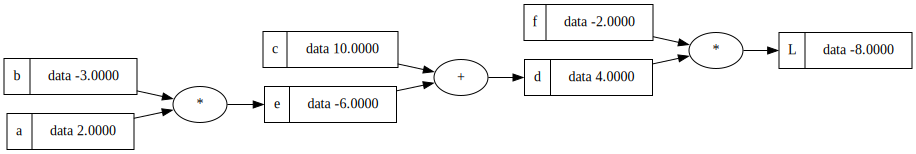

In [12]:
draw_dot(L, False)

Now that we can perform a forward pass of a simple arithmetic expression by computing the values, we want to know how changing the values going into the result node changes its value, which is given by the first derivative of the function. This is interesting for us, as later the calculated value is the *loss* of the neural network that depends on (1) the data (which we cannot change) and (2) the parameters of the model (which we change to minimize the loss). We store this value in the attribute `grad`.

In [13]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0                                         # New
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

**Backpropagation** refers to **calculating the derivative of every node** of the computation graph with respect to the loss, $L$. It consists of a *forward* and a *backward* pass. We have seen the forward pass above and can already compute the **backward pass** by hand. It is done by the *recursive application of the chain rule* backwards through the computation graph.

Recall that the derivative refers to the rate of change of $L$, if I change the input by $1$ unit.
Thus, for $L$ itself, it is simple: $\frac{\partial L}{\partial L} = 1$

In [14]:
L.grad = 1.0

From the computation graph, we know that $L$ depends on $d$ and $f$ in the following way: $$L(d, f) = d \cdot f$$

Now we calculate $\frac{\partial L}{\partial d} = f$ and $\frac{\partial L}{\partial f} = d$ by applying the *constant factor rule* (as we see $f$ as a constant when deriving with respect to $d$ and the other way round.)

Thus, we set:

In [15]:
d.grad = -2.0
f.grad = 4.0

The next step to calculate $\frac{\partial L}{\partial c}$ and $\frac{\partial L}{\partial e}$ is a bit harder.

First, we know how $c$ and $e$ influcene $d$: $$d(c, e) = c + e$$
Thus we also know the **local derivatives**: $\frac{\partial d}{\partial c} = 1$ and $\frac{\partial d}{\partial e} = 1$.

The following is the **most important thing to understand in this notebook**:
***We can apply the chain rule to compute how to chain derivatives together correctly!***

The formula for the chain rule looks like this: $\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \cdot \frac{\partial y}{\partial x}$.
> Intuitively, the chain rule states that knowing the instantaneous rate of change of $z$ relative to $y$ and that of $y$ relative to $x$ allows one to calculate the instantaneous rate of change of $z$ relative to $x$ as the product of the two rates of change. ~ [Chain rule (Wikipedia)](https://en.wikipedia.org/wiki/Chain_rule)

By chaining together the already computed derivative of $L$ with regard to $d$ ($\frac{\partial L}{\partial d} = f$) and the local derivative of $d$ with regard to $c$ ($\frac{\partial d}{\partial c} = 1$), we can compute:
$$\frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial c} = f \cdot 1$$
which is exactly what we are looking for.

Equivalently for $e$:
$$\frac{\partial L}{\partial e} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial e} = f \cdot 1$$

(We see that the $+$ node simply "routes" the gradient unchanged, because the local derivative is always equal to 1.)

In [16]:
c.grad = -2.0
e.grad = -2.0

We can calculate $\frac{\partial L}{\partial a}$ and $\frac{\partial L}{\partial b}$ in the same way.

First, we know how $a$ and $b$ influence $e$: $$e(a,b) = a \cdot b$$
The local derivatives are thus: $\frac{\partial e}{\partial a} = b$ and $\frac{\partial e}{\partial b} = a$.

The gradient of the output node is: $\frac{\partial L}{\partial e} = f$.

Thus, we obtain:
$$\frac{\partial L}{\partial a} = \frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial a} = f \cdot b$$
and:
$$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial b} = f \cdot a$$

In [17]:
a.grad = 6.0   # = -2.0 * -3.0
b.grad = -4.0  # = -2.0 * 2.0

We can draw the computation graph again, this time showing the gradient values.

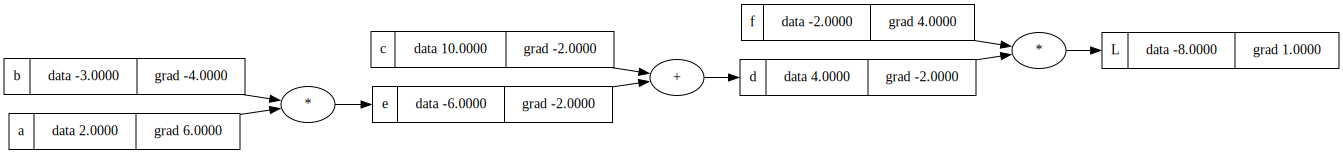

In [18]:
draw_dot(L)

This way we calculated one backward pass by hand :)

Now that we know how every variable (locally) influences the function output, we know how to change them to minimize/maximize the output.
At the end, that is exactly what we want to do: The function is our neural network and the variables are the weights of the network, which we want to tune in order to minimize the loss of our network.

It is nice to understand the concept, but we definitely do not always want to set the `grad` values *by hand*. So we implement a `_backward()` function for every arithmetical operation which computes the derivative according to the chain rule by multiplying the local derivative of the node with the gradient of the output node.

In [19]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None                              # New
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():                                           # New
            self.grad += 1.0 * out.grad                            # New
            other.grad += 1.0 * out.grad                           # New
        out._backward = _backward                                  # New
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():                                           # New
            self.grad += other.data * out.grad                     # New
            other.grad += self.data * out.grad                     # New
        out._backward = _backward                                  # New
        
        return out

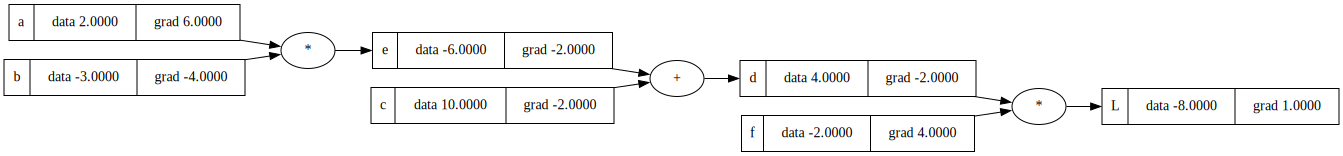

In [20]:
# Reinitialize the computation
# Inputs
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# Function
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'


# Applying _backward() from back to front to calculate the gradients in the backward pass
L.grad = 1.0
L._backward()
d._backward()
e._backward()
draw_dot(L)

We can now let the `_backward()` function set the gradients for us. But we also don't always want to pay attention to call the `_backward()` function for every node individually and in the right order, so we implement the `backward()` function which handles the recursive calls to the individual `_backward()` functions.

In [21]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def backward(self):               # New
        topo = []                     # New
        visited = set()               # New

        def build_topo(v):            # New
            if v not in visited:      # New
                visited.add(v)        # New
                for child in v._prev: # New
                    build_topo(child) # New
                topo.append(v)        # New

        build_topo(self)              # New

        self.grad = 1.0               # New
        for node in reversed(topo):   # New
            node._backward()          # New

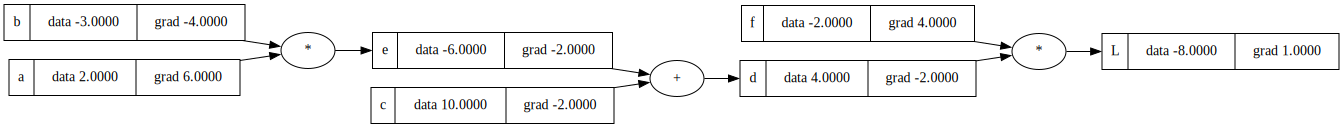

In [22]:
# Reinitialize the computation
# Inputs
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# Function
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'


# Single call to backward() function
L.backward()
draw_dot(L)

And that is fundamentally all we need.

The next cell adds a few more functions and comments to later be able to implement the calculations of neurons.

It is important to note that the arithmetic functions can be defined at **different levels of abstraction**. E.g. `tanh()` involves multiple "basic" functions like addition, subtraction, division and exponentiation. It is only important that we **know the local derivative** of all nodes!

In [23]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0                # For backward pass: gradient with respect to loss
        self._backward = lambda: None  # For backward pass: Function applying the chain rule: local gradient * output gradient
        self._prev = set(_children)    # For backward pass/visualization: predecessors of this node
        self._op = _op                 # For forward/backward pass: operation that produced this node
        self.label = label             # For visualization: display name for the node
  
    def __add__(self, other):
        """Called by "self + other"."""
        other = other if isinstance(other, Value) else Value(other)  # Allows to add values of other classes to Value objects by wrapping them in a Value object
        out = Value(self.data + other.data, (self, other), '+')      # The output of the add operation is the sum of the respective values, and the children are the summands

        def _backward():                # Called by backward() of Value class
            # Important to use '+=' and not only '=' (accumulating the gradient)
            # Otherwise: bug, if variable is used more than once
            self.grad += 1.0 * out.grad   # local derivative of add operation wrt self node * output gradient ("out.grad is chained through local gradient into self.grad")
            other.grad += 1.0 * out.grad  # local derivative of add operation wrt other node * output gradient
        out._backward = _backward

        return out

    def __mul__(self, other):
        """Called by "self * other"."""
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad  # local derivative of multiplication * output gradient
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        """Called by "self ** other"."""
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now."
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad  # local derivative of power operation * output gradient
        out._backward = _backward

        return out

    def tanh(self):
        """Implements hyperbolic tangent function as an example of an activation function."""
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad  # local derivative of tanh operation * output gradient
        out._backward = _backward

        return out

    def exp(self):
        """Implements e**x."""
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad  # local derivative of exp operation * output gradient

        out._backward = _backward
        return out

    def backward(self):
        """Function performing the whole backward pass."""
        # First, the computation graph has to be sorted topologically
        # A *topological sort* lays out a graph so that all edges only go from left to right
        # This is done to ensure that the _backward() functions are called in the right order
        # (only if _backward() of the later node(s) were already called)
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        # Accumulate gradients by passing from back to front of the graph
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            
  # --- Other functions that can be reduced to already implemented functions. ---

    def __neg__(self):
        """Called by "-self"."""
        return self * -1

    def __sub__(self, other):
        """Called by "self - other"."""
        return self + (-other)

    def __truediv__(self, other):
        """Called by "self / other"."""
        return self * other**-1

    def __radd__(self, other):
        """Called by "other + self"."""
        return self + other

    def __rsub__(self, other):
        """Called by "other - self"."""
        return other + (-self)

    def __rmul__(self, other):
        """Called by "other * self"."""
        return self * other

    def __rtruediv__(self, other):
        """Called by "other / self"."""
        return other * self**-1

    def __repr__(self):
        """Called by print() function."""
        return f"Value(data={self.data})"

And that is all there is for the `Value` class.

# Backpropagation on a simple neuron

Now that we have seen how we can implement and perform backpropagation on a simple function, we go on with the **implementation of a simple neuron** taking two values as inputs and giving one value as output.

It computes the function: $f(x_1, x_2) = \tanh(w_1x_1 + w_2x_2 + b)$
- $x_1$, $x_2$: Inputs
- $w_1$, $w_2$: Weights
- $b$: Bias
- $\tanh$: Activation function

We define the inputs, weights and bias as `Value` objects, and how they are combined to produce the output.

The computation graph of the simple neuron is depicted below.

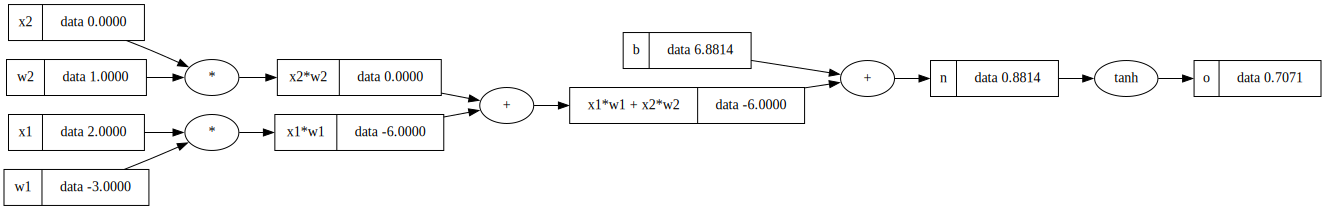

In [24]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron (weird value to obtain prettier derivatives)
b = Value(6.8813735870195432, label='b')

# Computation of the neuron (weighted sum): x1*w1 + x2*w2 - b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2';
n = x1w1x2w2 + b; n.label = 'n'

# Output = activation function(weighted sum)
o = n.tanh(); o.label = 'o'

draw_dot(o, False)

- Hint: If you execute the next cell *multiple times*, you have to reset the `grad` values to `0` ("[zero_grad](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)") before calling `backward()` again, because otherwise the gradient will be wrong, as it gets accumulated!

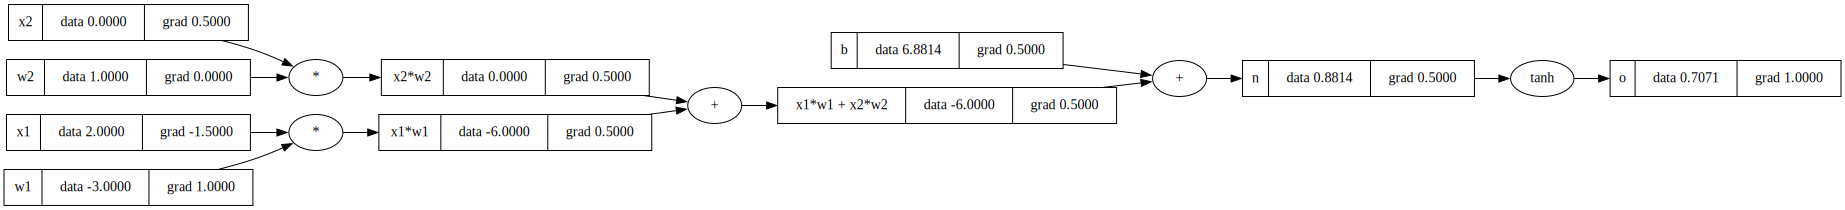

In [25]:
o.backward()
draw_dot(o)

# Backpropagation with PyTorch

In practice you of course will not implement backpropagation by yourself, but use a framework like PyTorch for that purpose. PyTorch works in the same way as our implementation, but is more efficient, as `Tensor`s are used (enables parallelism).

The same calculations as above implemented in PyTorch look like this:

In [26]:
import torch

x1 = torch.Tensor([2.0]).double();               x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();               x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();              w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();               w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---\nGradient values:")
print(f"x1: {x1.grad.item():.4f}")
print(f"x2: {x2.grad.item():.4f}")
print(f"w1: {w1.grad.item():.4f}")
print(f"w2: {w2.grad.item():.4f}")

0.7071066904050358
---
Gradient values:
x1: -1.5000
x2: 0.5000
w1: 1.0000
w2: 0.0000


We see that the gradient values correspont to the gradients we calculated using our own implementation.

# Introducing the `Neuron`, `Layer` and `MLP` class

Now that we understand how backpropagation can be performed on a *simple function* and a *tiny neuron*, we can ramp up the complexity.

Remember that all **neural networks** are simply a **certain class of mathematical expressions**.
They have *data* and their *weights* as inputs and output *predictions*.
However, they usually are not written out as a whole mathematical function because they are just to *massive*.
This is also the reason why symbolic differentiation to calculate an optimum is not feasable, which is why we resolve to automatic differentiation, and more precisely: backpropagation.

The next cell defines the `Module`, `Neuron`, (fully connected) `Layer` and `MLP` class. As basic knowledge of Deep Learning (DL) parlance is assumed, and DL is not the main focus of this notebook here is just a small recap:
- `Module`: Class every other class inherits from, provides base functionality (equivalent to PyTorch)
- `Neuron`: Computes a weighted sum of its inputs and applies an activation function
- `Layer`: Multiple `Neuron`s performing computations in parallel
- `MLP`: Multiple `Layer`s performing computations sequentially

In [27]:
class Module:
    """Base class every component of neural networks inherits from.

    Mimicks the architecture of pytorch."""

    def zero_grad(self):
        """Reset the grad value for all parameters.

        Because we accumulate the gradient values (+=) in the Value class,
        we have to set them to 0 when we calculate the gradient the next time.
        """
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []


class Neuron(Module):

    def __init__(self, nin):
        """Initialize the neuron by setting the weights and the bias to random values.

        Args:
            nin (int): Number of inputs to the neuron."""
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        """Called when executing 'Neuron(nin)(x)'.

        Calculates the weighted sum of its inputs (w*x+b) 
        and applies tanh as the activation function.

        Args:
            x (list(int)): Input to the neuron"""
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        """Reuturn all parameter values of the neuron."""
        return self.w + [self.b]  # Last value is bias

    def __repr__(self):
        return f"Neuron{self.parameters()}"


class Layer(Module):

    def __init__(self, nin, nout):
        """Initialize the layer by initializing its neurons.

        Args:
            nin (int): Number of inputs to each neuron.
            nout (int): Number of neurons of the layer."""
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        """Called when executing 'Layer(nin, nout)(x)'.

        Calculates the outputs of all the layers neurons.

        Args:
            x (list(int)): Input to the layer."""
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out   # Single value if the layer has only 1 neuron, otherwise a list of values

    def parameters(self):
        """Reuturn all parameter values of the layer."""
        return [p for neuron in self.neurons for p in neuron.parameters()]

    def __repr__(self):
        return f"Layer[#{f',#'.join(str(neuron) for neuron in self.neurons)}\n  ]".replace("#", "\n    ")


class MLP(Module):

    def __init__(self, nin, nouts):
        """Initialize the MLP by initializing its layers.

        Args:
            nin (int): Number of inputs to the MLP's first layer.
            nouts (list(int)): Number of neurons of the layers."""
        nneurons =  [nin] + nouts
        self.layers = [Layer(nneurons[i], nneurons[i+1]) for i in range(len(nouts))]  # nouts layers with the number of each layers inputs corresponding to the number of outputs of the previous layer

    def __call__(self, x):
        """Called when executing 'MLP(nin, nouts)(x)'.

        Calculates the outputs of the MLP.

        Args:
            x (list(int)): Input to the MLP."""
        for layer in self.layers:  # Call all layers sequentially
            x = layer(x)
        return x

    def parameters(self):
        """Reuturn all parameter values of the MLP."""
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP[\n  {f',#'.join(str(layer) for layer in self.layers)}\n]".replace("#", "\n  ")

# Optimizing an MLP with backpropagation

Now, we can define a simple MLP and look at it's parameters.

In [28]:
n = MLP(3, [4, 4, 1])
print(n)

MLP[
  Layer[
    Neuron[Value(data=-0.4227268789708458), Value(data=-0.3233877207446141), Value(data=0.788298972344351), Value(data=0.82178935438011)],
    Neuron[Value(data=-0.5784068487158849), Value(data=0.6064952565683153), Value(data=0.5149751904181639), Value(data=-0.24662997147886667)],
    Neuron[Value(data=-0.7525617628012391), Value(data=0.3493014394532439), Value(data=-0.2140055579275244), Value(data=-0.9483360066150508)],
    Neuron[Value(data=0.5259213810970667), Value(data=-0.17697589930931312), Value(data=0.26658483475848094), Value(data=0.5304559752557796)]
  ],
  Layer[
    Neuron[Value(data=0.5270700987699946), Value(data=0.2094842783641686), Value(data=0.06252488431593828), Value(data=0.1341300698225616), Value(data=0.40984379334108945)],
    Neuron[Value(data=0.5075642009135815), Value(data=-0.763303974716842), Value(data=-0.12364506187070878), Value(data=0.6102093028982132), Value(data=0.7297048006294433)],
    Neuron[Value(data=-0.06472075714092429), Value(data=-

Now that we have defined the architecture, we can define some inputs and some outputs we want the model to learn.

In [29]:
# (Row-wise) inputs for the neural network
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
# Labels for the inputs
ys = [1.0, -1.0, -1.0, 1.0]

The **loss** calculates a single number that measures the performance of the network. The greater the loss, the worse the predictions of the network.

In [30]:
def loss(y, ypred):
    """Calculates the Mean Squared Error (MSE).
  
    Args:
        y (list(int)): Labels of the data.
        ypred (list(int)): Predictions of the model."""
    return sum((ys - ypreds)**2 for ys, ypreds in zip(y, ypred))

In the *forward pass* of the neural network, the internal state (activations of the neurons) is determined.

In [31]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.294680807270923),
 Value(data=0.40878104481104927),
 Value(data=0.6975375854717788),
 Value(data=0.27853533911951606)]

We can determine the loss of the model:

In [32]:
l = loss(ys, ypred)
l

Value(data=5.884284306839657)

In the *backward pass*, we apply determine the gradients of all neurons (using the computation graph to calculate the loss):

In [33]:
l.backward()

The gradient for every single neuron can be inspected:

In [34]:
n.layers[0].neurons[0].w[0].grad

0.9979313029003757

And also the whole computation graph of the MLP (which is quite huge --- already for a simple network like this!):

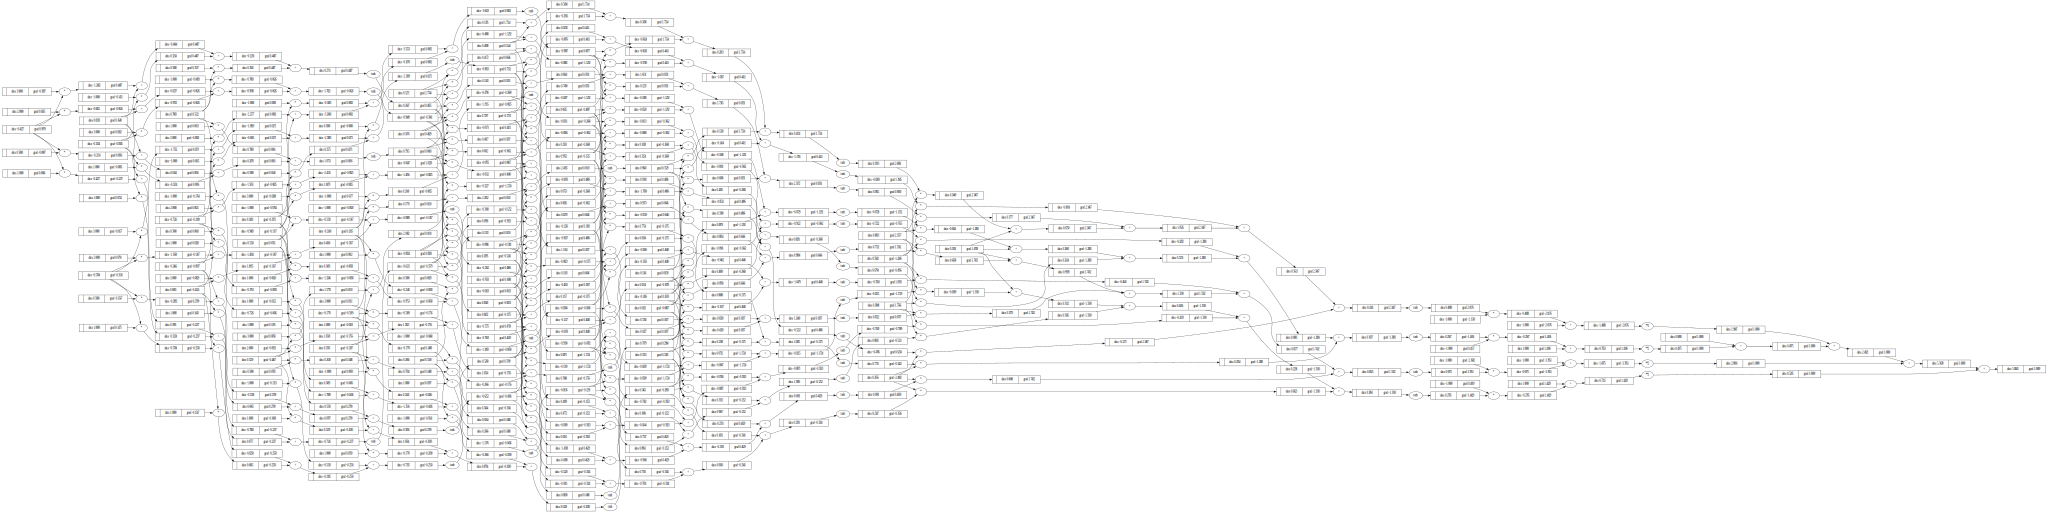

In [35]:
draw_dot(l)

Now that we have determined the gradients with the help of backpropagation, we can perform **gradient descent** in the parameter space of the model.

(Note that the gradients are also calculated on the *input data*, which is not that useful, as it is fixed, so we just ignore them.)

In [36]:
lr = 0.01  # Learning rate = Step size of updates

for p in n.parameters():    # Update all parameters of the model
    p.data += -lr * p.grad  # Gradients point "uphill" -> As we want to *minimize* the loss, we need to negate the update

This was exactly *one* optimization step.

The loss value for new predictions (on the same data) should now be smaller:

In [37]:
# New forward pass
ypred = [n(x) for x in xs]

# Calculate loss
l = loss(ys, ypred)
l

Value(data=5.5409744296525165)

One step is not really that effective, so we do a lot of steps, in our case $100$, but usually a lot more ;).

This procedure is called the **training loop** and consists of the:
1. *Forward pass*: Make predictions
2. Calculation of the *loss*
3. *Backward pass*: Calculate gradients
4. *Gradient descent step*: Weight update

In [38]:
lr = 0.01

for k in range(100):
    # Forward pass
    ypred = [n(x) for x in xs]
    # Calcualte loss
    l = loss(ys, ypred)
    # Backward pass
    n.zero_grad()
    l.backward()
    # Gradient descent step
    for p in n.parameters():
        p.data += -lr * p.grad
    # Print the loss
    print(f"Iteration {k}, loss = {l.data}")

Iteration 0, loss = 5.5409744296525165
Iteration 1, loss = 5.189744096916597
Iteration 2, loss = 4.8371371062960495
Iteration 3, loss = 4.489291156078554
Iteration 4, loss = 4.15035325553338
Iteration 5, loss = 3.8230098943281052
Iteration 6, loss = 3.5094631673092147
Iteration 7, loss = 3.2117647498990816
Iteration 8, loss = 2.931598461314019
Iteration 9, loss = 2.6700209459256445
Iteration 10, loss = 2.4274330858027287
Iteration 11, loss = 2.2037381024215845
Iteration 12, loss = 1.9985319840960387
Iteration 13, loss = 1.8112283292743003
Iteration 14, loss = 1.641107475757602
Iteration 15, loss = 1.487324775933295
Iteration 16, loss = 1.348913947874489
Iteration 17, loss = 1.2248038072209608
Iteration 18, loss = 1.113850032172237
Iteration 19, loss = 1.0148750774793558
Iteration 20, loss = 0.9267079894671764
Iteration 21, loss = 0.8482182059243173
Iteration 22, loss = 0.7783405688647732
Iteration 23, loss = 0.7160912659223658
Iteration 24, loss = 0.660575871656207
Iteration 25, loss =

We see that the loss shrinks, indicating our model fitting the data better.
Now we can look at the new predictions of our MLP:

In [39]:
ypred

[Value(data=0.9599269004843021),
 Value(data=-0.9128309548825686),
 Value(data=-0.8480721877597093),
 Value(data=0.8484084543331494)]

They are a lot closer to the labels than our first predictions! We have **optimized** on our model with the help of backpropagation.

We can visualize the computation graph of the loss on our model again (and see that the gradients are a lot smaller than before because our error gets smaller):

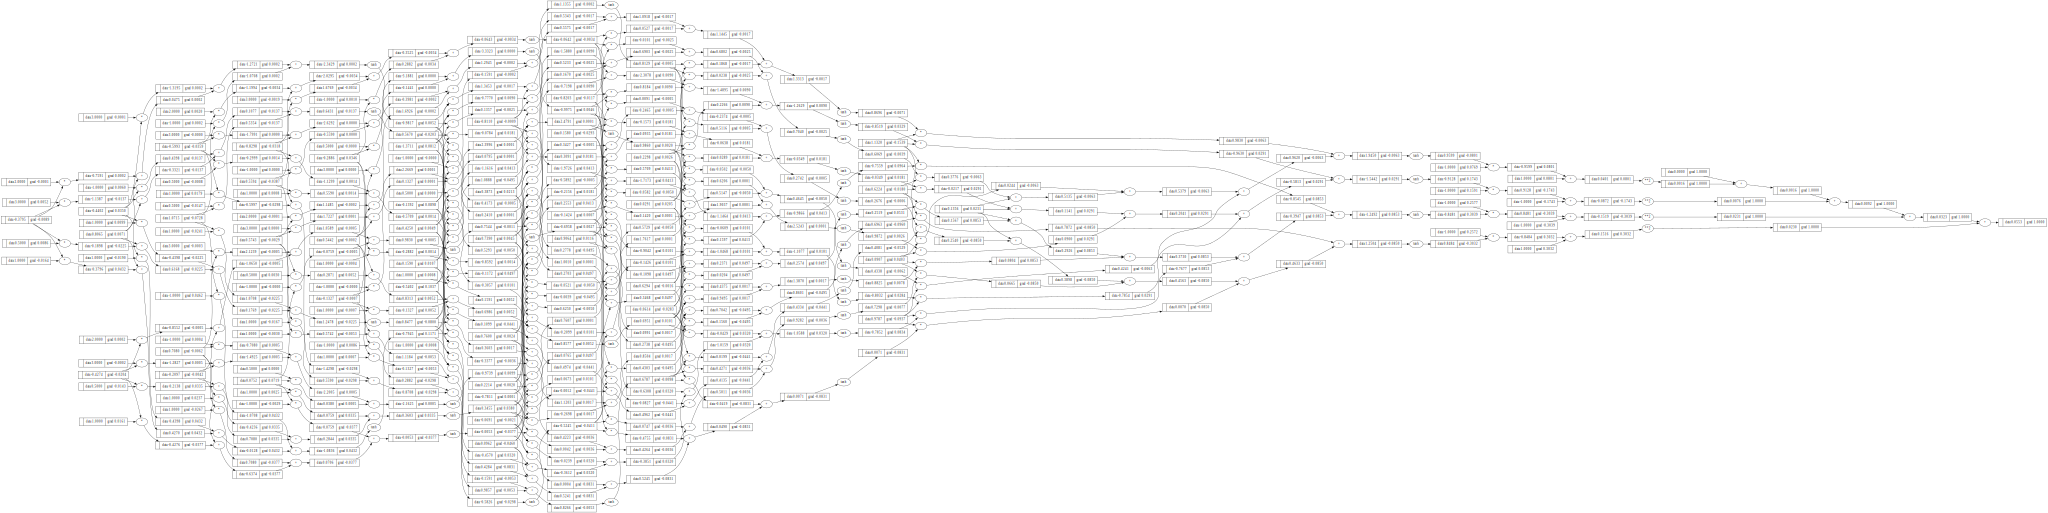

In [40]:
draw_dot(l)

That's it. Now you know that...
- ... neural networks are optimized via backpropagation.
- ... backpropagation is an example of automatic differentiation.
- ... backpropagation consists of a forward pass and a backward pass.
- ...